In [1]:
%matplotlib notebook

In [2]:

from importlib import reload
import two_transmons.DoubleTransmonSystem
from two_transmons.DoubleTransmonSystem import *
import two_transmons.VacuumRabiSimulation
from two_transmons.VacuumRabiSimulation import *
import single_transmon.Transmon
from single_transmon.Transmon import *
from ReadoutResonator import *
from qutip import *
from tqdm.notebook import tqdm
from two_transmons.ZPulse import *
from importlib import reload
import two_transmons.ParallelCalculations
from two_transmons.ParallelCalculations import *
from two_transmons.CalcTime import *
from two_transmons.Tomography import *
from scipy.linalg import cholesky
from p_tqdm import p_map, p_imap
import time
import numpy as np
from numpy import dot
from copy import deepcopy
from transmon_chain.transmon_chain import *
from two_transmons.Vacuum_rabi_windows import *

In [3]:
Nc = 7
N_trunc = 3
Ec1 = 0.25 * 2 * np.pi
Ec2 = 1.03*Ec1
Ecc = 0.01/1.2**2 * 2 * np.pi # 1.2 is my estimate for n_{ge} matrix element
Ej1 = Ec1 * 100
Ej2 = Ec2 * 100
d = 0.2

T1_1, T2_1 = 1e3, 1e3
T1_2, T2_2 = 1e3, 1e3
T1_3, T2_3 = 5e3, 1e3
T1_4, T2_4 = 5e3, 1e3

tr1 = Transmon(Ec1, Ej1, d, 1/T1_1, 1/T2_1, Nc, N_trunc, 1)
tr2 = Transmon(Ec2, Ej2, d, 1/T1_2, 1/T2_2, Nc, N_trunc, 2)
tr3 = Transmon(Ec2, Ej2, d, 1/T1_3, 1/T2_3, Nc, N_trunc, 3)
tr4 = Transmon(Ec1, Ej1, d, 1/T1_4, 1/T2_4, Nc, N_trunc, 4)
dts = DoubleTransmonSystem(tr1, tr2, Ecc)
r = ReadoutResonator(6, 1118, 1964, phi=0.29)
r.set_qubit_parameters(.05, 0.05, 5, 5.3, .2, .2)


freq_lim = 0.2
farg=cook_farg(20,freq_lim)
params=farg[0]['params']
Ts = linspace(0, params["finish"], params['t_points'])
T = Tomography(dts, Ts, params, r)


/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [4]:
tr1.c_ops(0.5)

[Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
 Qobj data =
 [[0.         0.03162278 0.        ]
  [0.         0.         0.04207994]
  [0.         0.         0.        ]],
 Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[0.         0.         0.        ]
  [0.         0.03162278 0.        ]
  [0.         0.         0.05599512]]]

In [5]:
chain = TransmonChain(4, transmon_truncation = 3)
chain.set_phi((params['phi_base_level'] + params['phi_offset'],params['phi2z_base_level'],0.6,0.7))
chain._transmons = [tr1, tr2,tr3,tr4]
#chain.set_J([0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5])
chain.set_J(0.01/1.2**2 * 2 * np.pi*2)
chain.build_low_energy_kets(2,0)
chain._Ts = Ts
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
chain.rho0 = rho0
chain.set_e_ops()
'''sigma_z_chain = []
sigma_x_chain = []
sigma_y_chain = []
for i in range (4): #TO DO - вынести в функцию класса
    sigma_z = chain._transmons[i].sz()
    sigma_x = chain._transmons[i].sx()
    sigma_y = chain._transmons[i].sy()
    oper_z = chain._identity_array.copy()
    oper_z[i]=sigma_z
    oper_x = chain._identity_array.copy()
    oper_x[i]=sigma_x
    oper_y = chain._identity_array.copy()
    oper_y[i]=sigma_y
    sigma_z_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_z)))
    sigma_x_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_x)))
    sigma_y_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_y)))

chain.e_ops = sigma_z_chain + sigma_x_chain + sigma_y_chain
'''

Setting all J to be equal
Total 15 kets included


'sigma_z_chain = []\nsigma_x_chain = []\nsigma_y_chain = []\nfor i in range (4): #TO DO - вынести в функцию класса\n    sigma_z = chain._transmons[i].sz()\n    sigma_x = chain._transmons[i].sx()\n    sigma_y = chain._transmons[i].sy()\n    oper_z = chain._identity_array.copy()\n    oper_z[i]=sigma_z\n    oper_x = chain._identity_array.copy()\n    oper_x[i]=sigma_x\n    oper_y = chain._identity_array.copy()\n    oper_y[i]=sigma_y\n    sigma_z_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_z)))\n    sigma_x_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_x)))\n    sigma_y_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_y)))\n\nchain.e_ops = sigma_z_chain + sigma_x_chain + sigma_y_chain\n'

# Свободная эволюция системы

### 1й и 2й кубит в цепочке в резонансе, изначально первый кубит возбуждён

In [6]:
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0[0] = ket2dm((basis(3,1) + basis(3,0))/sqrt(2)) # задаём начальное состояние 1го кубита
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
waveform1_const = ones_like(Ts)*(params['phi_base_level']+params['phi_offset'])
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7


H_full_test = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[0,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full_test, rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

/tmp/ipykernel_2771395/3453723927.py:5: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform1_const = ones_like(Ts)*(params['phi_base_level']+params['phi_offset'])
/tmp/ipykernel_2771395/3453723927.py:6: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
/tmp/ipykernel_2771395/3453723927.py:7: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform3_const = ones_like(Ts)*0.6
/tmp/ipykernel_2771395/3453723927.py:8: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform4_const = ones_like(Ts)*0.7


10.0%. Run time:   0.76s. Est. time left: 00:00:00:06
20.0%. Run time:   1.40s. Est. time left: 00:00:00:05
30.0%. Run time:   2.05s. Est. time left: 00:00:00:04
40.0%. Run time:   2.72s. Est. time left: 00:00:00:04
50.0%. Run time:   3.36s. Est. time left: 00:00:00:03
60.0%. Run time:   4.01s. Est. time left: 00:00:00:02
70.0%. Run time:   4.65s. Est. time left: 00:00:00:01
80.0%. Run time:   5.29s. Est. time left: 00:00:00:01
90.0%. Run time:   5.94s. Est. time left: 00:00:00:00
Total run time:   6.58s


<IPython.core.display.Javascript object>


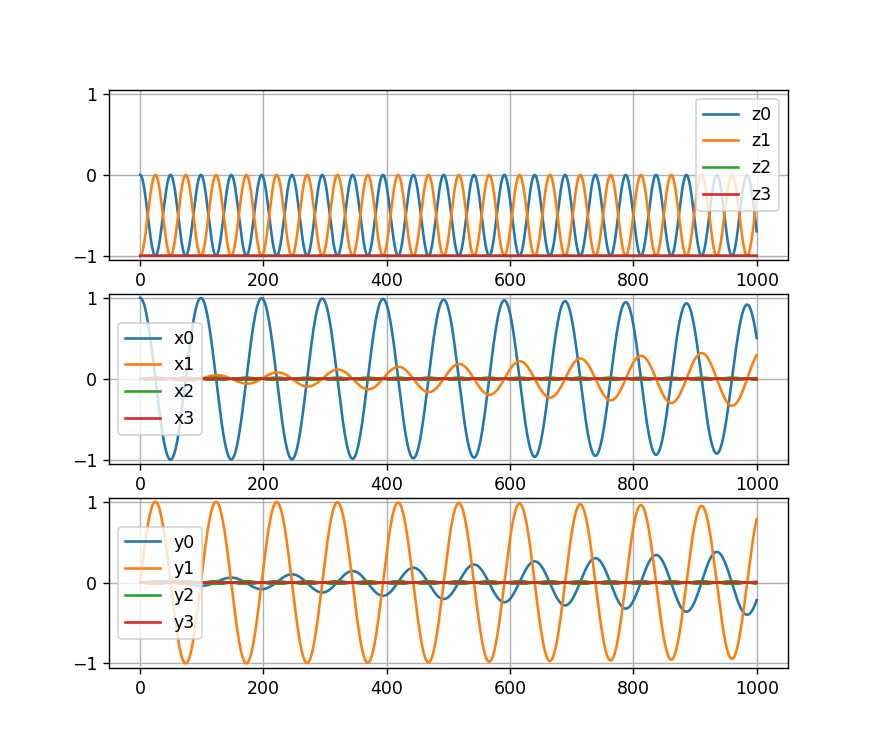

(<Figure size 700x600 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [7]:
chain.plot_chain_dynamic(result)

## Эволюция под действием внешнего поля

### Кубиты не в резонансе, поле действует на первый и третий кубиты

In [8]:
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))

In [9]:
waveform1_const = ones_like(Ts)*(params['phi_base_level'])
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7

/tmp/ipykernel_2771395/3360535585.py:1: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform1_const = ones_like(Ts)*(params['phi_base_level'])
/tmp/ipykernel_2771395/3360535585.py:2: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
/tmp/ipykernel_2771395/3360535585.py:3: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform3_const = ones_like(Ts)*0.6
/tmp/ipykernel_2771395/3360535585.py:4: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform4_const = ones_like(Ts)*0.7


/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


10.0%. Run time:   0.35s. Est. time left: 00:00:00:03
20.0%. Run time:   1.41s. Est. time left: 00:00:00:05
30.0%. Run time:   3.20s. Est. time left: 00:00:00:07
40.0%. Run time:   4.99s. Est. time left: 00:00:00:07
50.0%. Run time:   6.79s. Est. time left: 00:00:00:06
60.0%. Run time:   8.59s. Est. time left: 00:00:00:05
70.0%. Run time:  10.39s. Est. time left: 00:00:00:04
80.0%. Run time:  12.18s. Est. time left: 00:00:00:03
90.0%. Run time:  14.01s. Est. time left: 00:00:00:01
Total run time:  15.82s


<IPython.core.display.Javascript object>


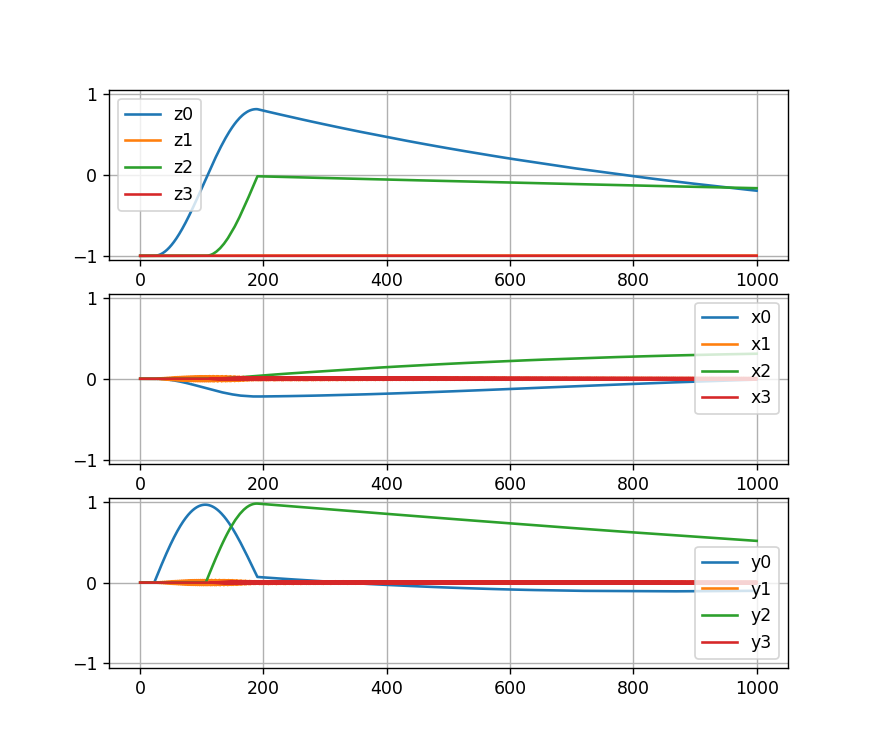

(<Figure size 700x600 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [10]:
H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration*1.0,0],[0,0],[T._pi_duration/2,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = chain.build_c_ops(), e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

### 1й, 2й и 3й кубиты в резонансе, поле действует на первый

In [4]:
waveform1_const = ones_like(Ts)*(params['phi_base_level'] + params['phi_offset'] )
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform4_const = ones_like(Ts)*0.7
chain.set_phi((params['phi_base_level'] + params['phi_offset'],params['phi2z_base_level'],params['phi2z_base_level'],0.7))

H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

/tmp/ipykernel_2771395/1916907863.py:1: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform1_const = ones_like(Ts)*(params['phi_base_level'] + params['phi_offset'] )
/tmp/ipykernel_2771395/1916907863.py:2: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
/tmp/ipykernel_2771395/1916907863.py:3: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform3_const = ones_like(Ts)*(params['phi2z_base_level'])
/tmp/ipykernel_2771395/1916907863.py:4: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform4_const = ones_like(Ts)*0.7


NameError: name 'chain' is not defined

## Vacuum rabi oscillations

Приготавливаем первый кубит в возбуждённом состоянии, затем на какое-то время перестраиваем его по потоку. При попадании в резонанс со вторым кубитом наблюдаются осцилляции заселённости возбуждённого состояния 1-го и 2-го кубитов. Можно построить зависимость заселённости второго кубита от отстройки по потоку и времени взаимодействия. 

In [13]:
signal = ZPulse(Ts,params)
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))


    

## Форма потокового импульса, подающегося на первый кубит (для одного значения параметров)

<IPython.core.display.Javascript object>


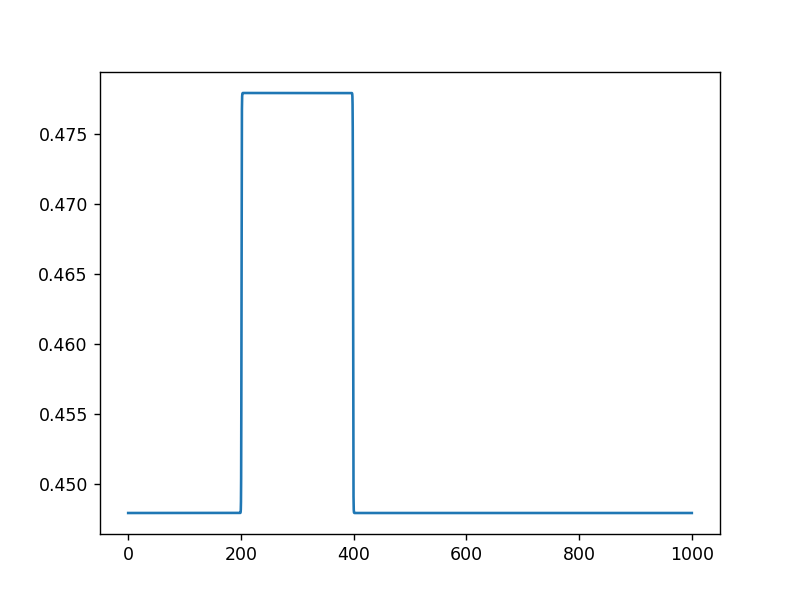

In [14]:
figure()
plot(Ts, vacuum_rabi_waveform(200, 0.03, Ts, params)[0])

In [15]:
##special for windows 
'''
durations = linspace (50, 700, 200)
phis = linspace (0.027, 0.033, 200)
size = len(phis)
args = []
for ind, phi in enumerate (phis):
    dict_arg = {'chain' : chain, 'params' : params, 'durations' : durations, 'phi_offset' : phi}
    args.append(dict_arg)
    
'''


In [16]:
'''
if __name__=='__main__':
    with Pool(24) as p:
        populations = p.map(vacuum_rabi_populations_one_phi_windows, tqdm(args))
        '''

  0%|                                                                                           | 0/200 [00:00<?, ?it/s]/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_

In [20]:
durations = linspace (50, 250, 50)
phis = linspace (0.025, 0.035, 200)
size = len(phis)

populations1 = p_map(vacuum_rabi_populations_one_phi,[chain]*size, [params]*size, [durations]*size, phis, num_cpus = 20)

    
    

  0%|          | 0/200 [00:00<?, ?it/s]

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/alexeitolstobrov/serve

KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap


  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/home/alexeitolstobrov/Examples/transmon-simulations/two_transmons/Vacuum_rabi_win

  File "/home/alexeitolstobrov/Examples/transmon-simulations/two_transmons/Vacuum_rabi_windows.py", line 23, in vacuum_rabi_populations_one_phi
    populations_one_phi.append(vacuum_rabi_population(chain, params, dur, phi_offset))
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 433, in integrate
    self._y, self.t = mth(self.f, self.jac or (lambda: None),
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/qutip/mesolve.py", line 539, in _generic_ode_solve
    output.expect[m][t_idx] = expect_rho_vec(e_ops_data[m], r.y,
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/qutip/qobjevo.py", line 169, in __call__
   

  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/alexeitolstobrov/Examples/transmon-simulations/two_transmons/Vacuum_rabi_windows.py", line 15, in vacuum_rabi_population
    result = mesolve(H_full, chain.rho0, chain._Ts, c_ops = [], e_ops = chain.e_ops,
  File "/home/alexeitolstobrov/Examples/transmon-simulations/two_transmons/Vacuum_rabi_windows.py", line 15, in vacuum_rabi_population
    result = mesolve(H_full, chain.rho0, chain._Ts, c_ops = [], e_ops = chain.e_ops,
  File "qutip/cy/cqobjevo.pyx", line 691, in qutip.cy.cqobjevo.CQobjEvoTd._mul_vec
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/interpolate/interpolate.py", line 939, in __call__
    self._evaluate(x, nu, extrapolate, out)
  File "/home/alexeitolstobrov/Examples/transmon-simulations/two_transmons/Vacuum_rabi_windows.py", line 15, in vacuum_rabi_population
    result = mesolve(H_full, chain.rho0, cha

  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1009, in run
    y1, t, istate = self.runner(*args)
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/qutip/mesolve.py", line 544, in _generic_ode_solve
    r.integrate(r.t + dt[t_idx])
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 433, in integrate
    self._y, self.t = mth(self.f, self.jac or (lambda: None),
  File "/home/alexeitolstobrov/Examples/transmon-simulations/qobjevo_compiled_coeff_438234013136320.py", line 73, in __call__
    def __call__(self, t, args={}):
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "qutip/cy/cqobjevo.pyx", line 691, in qutip.cy.cqobjevo

  File "qutip/cy/cqobjevo.pyx", line 305, in qutip.cy.cqobjevo.CQobjEvo._factor_dyn
  File "/home/alexeitolstobrov/Examples/transmon-simulations/qobjevo_compiled_coeff_438234012436320.py", line 73, in __call__
    def __call__(self, t, args={}):
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/interpolate/interpolate.py", line 1009, in _evaluate
    _ppoly.evaluate(self.c.reshape(self.c.shape[0], self.c.shape[1], -1),
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 358, in y
    @property
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/interpolate/interpolate.py", line 939, in __call__
    self._evaluate(x, nu, extrapolate, out)
  File "/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1009, in run
    y1, t, istate = self.runner(*args)
  File "/home/alexeitolstobrov/Examples/transmon-simulations/qobjevo_compiled_coeff_438234012136290.py", line 73, in _

<IPython.core.display.Javascript object>


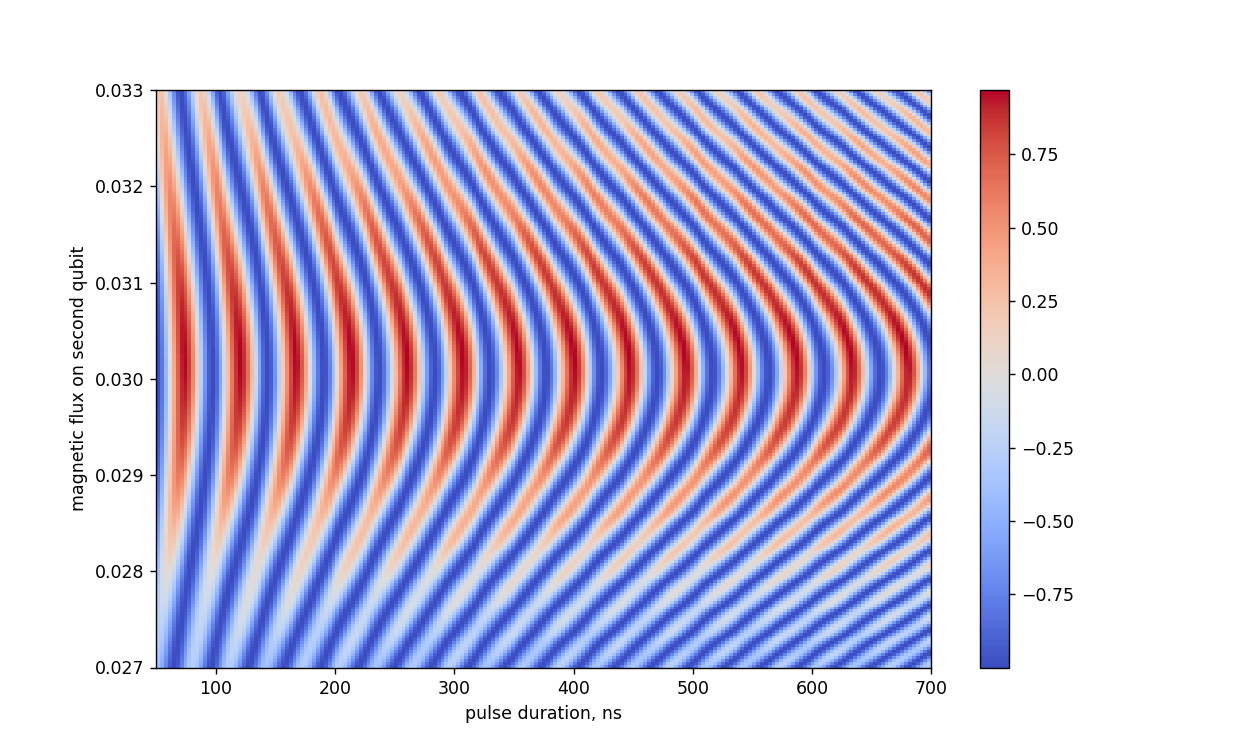

/tmp/ipykernel_2173015/568560534.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  image = ax.pcolormesh(durations,phis,populations, cmap = cm.coolwarm)


In [19]:
fig, ax = subplots(1,1,figsize=[10,6])
image = ax.pcolormesh(durations,phis,populations, cmap = cm.coolwarm)
fig.colorbar(image, ax=ax)
ax.set_xlabel('pulse duration, ns')
ax.set_ylabel('magnetic flux on second qubit')
#fig.savefig('02.02.2022_Vacuum_Rabi_big.png')

<IPython.core.display.Javascript object>


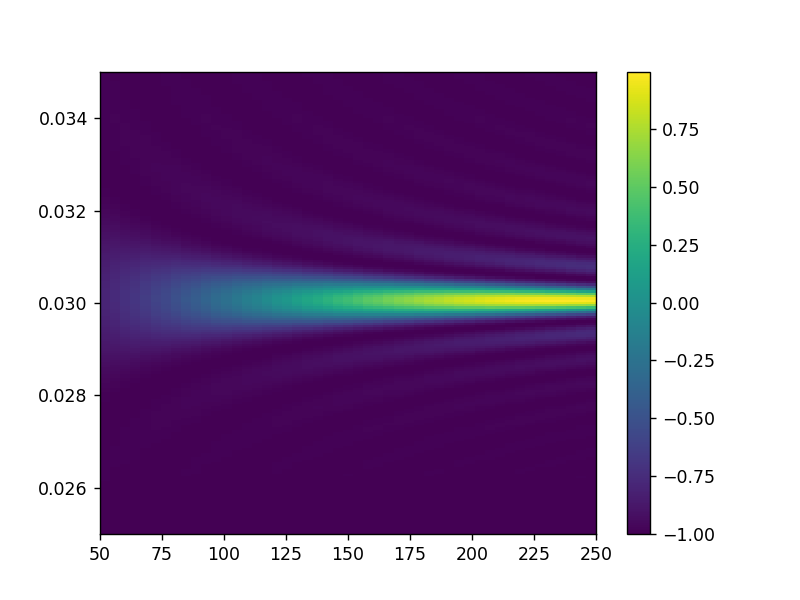

/tmp/ipykernel_1874116/182782353.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(durations, phis, populations)


In [11]:
figure()
pcolormesh(durations, phis, populations)
colorbar()
#savefig('23.01.2022_vacuum_rabi_4q.png')

## Iswap Gate

Пример эволюции кубитов при проведении гейта i-swap, первый кубит изначально переводится в состояние на экваторе сферы блоха, 
далее первый и второй кубиты переводятся в резонанс, после этого проводится фазовая коррекция с помощью Z-гейта.  

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


10.0%. Run time:   0.95s. Est. time left: 00:00:00:08
20.0%. Run time:   2.09s. Est. time left: 00:00:00:08
30.0%. Run time:   2.62s. Est. time left: 00:00:00:06
40.0%. Run time:   3.14s. Est. time left: 00:00:00:04
50.0%. Run time:   3.66s. Est. time left: 00:00:00:03
60.0%. Run time:   4.18s. Est. time left: 00:00:00:02
70.0%. Run time:   4.71s. Est. time left: 00:00:00:02
80.0%. Run time:   5.23s. Est. time left: 00:00:00:01
90.0%. Run time:   5.74s. Est. time left: 00:00:00:00
Total run time:   6.27s


<IPython.core.display.Javascript object>


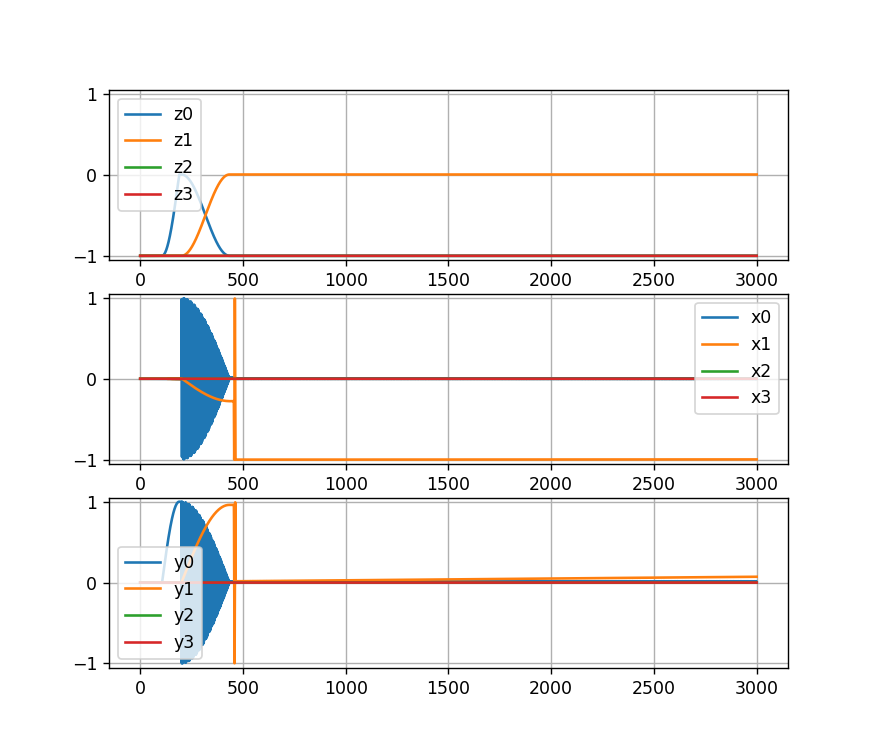

(<Figure size 700x600 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [13]:
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))
chain.set_J([0.01/1.2**2 * 2 * np.pi/5, 0,0,0])
signal = ZPulse(Ts,params)
waveform1 = signal.waveform_iswap_zgate(1)
waveform2 = signal.waveform_iswap_zgate(2)
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7
H_full = chain.build_H_full([waveform1, waveform2, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration/2,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

## Спектр системы в зависимости от потока через первый кубит

In [14]:
levels = []

phis = linspace(0, 1, 3000)
for phi in tqdm(phis):
    phi_arr = [0.25, .5 , .6, .7]
    phi_arr[0] = phi
    chain.set_phi(phi_arr)
    waveform1_const = ones_like(Ts)*phi_arr[0]
    waveform2_const = ones_like(Ts)*phi_arr[1]
    waveform3_const = ones_like(Ts)*phi_arr[2]
    waveform4_const = ones_like(Ts)*phi_arr[3]
    H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[0,0],[0,0],[0,0],[0,0]])
    H_const = chain.truncate_to_low_population_subspace(chain._zero_op)
    for i in range (12):
        if (i%3 != 2):
            H_const+=H_full[i][0]*H_full[i][1][0]
    for i in range(13,19,1):
        H_const+=H_full[i][0]
    evals, evecs = H_const.eigenstates()
    levels.append((evals-evals[0])/2/pi)

/tmp/ipykernel_2512868/647804778.py:3: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phis = linspace(0, 1, 3000)
  0%|                                                                                          | 0/3000 [00:00<?, ?it/s]/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|███████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:39<00:00, 30.05it/s]


<IPython.core.display.Javascript object>


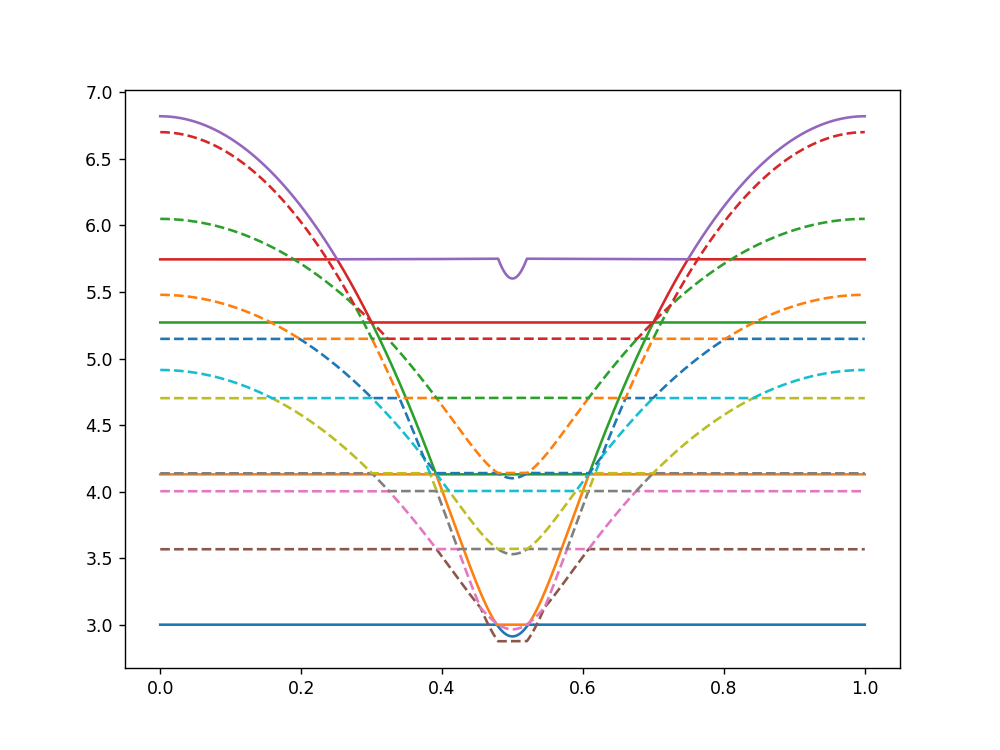

/home/alexeitolstobrov/server/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/alexeitolstobrov/server/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [15]:
figure()
plot(phis, array(levels)[:, 1:6])
plot(phis, array(levels)[:, 6:21]/2, "--")

# Вакуумные Раби-осцилляции для цепочки из 2 кубитов

In [11]:
chain2 = TransmonChain(2, transmon_truncation = 3)
chain2.set_phi((params['phi_base_level'] + params['phi_offset'],params['phi2z_base_level']))
chain2._transmons = [tr1, tr2]
#chain.set_J([0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5])
chain2.set_J(0.01/1.2**2 * 2 * np.pi*2)
chain2.build_low_energy_kets(2,0)
chain2._Ts = Ts
rho0_2 = [ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0_2 = tensor(*rho0_2)
rho0_2 = chain2.truncate_to_low_population_subspace(rho0_2)
chain2.rho0 = rho0_2
chain2.set_e_ops()

Setting all J to be equal
Total 6 kets included


In [15]:
signal = ZPulse(Ts,params)
chain2.set_phi((params['phi_base_level'],params['phi2z_base_level']))
durations = linspace (50, 700, 200)
phis = linspace (0.027, 0.033, 192)
size = len(phis)

populations2 = p_map(vacuum_rabi_populations_onephi_2qubits,
                     [chain2]*size, [params]*size, [durations]*size, phis, num_cpus = 24)



  0%|          | 0/192 [00:00<?, ?it/s]

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/alexeitolstobrov/serve

<IPython.core.display.Javascript object>


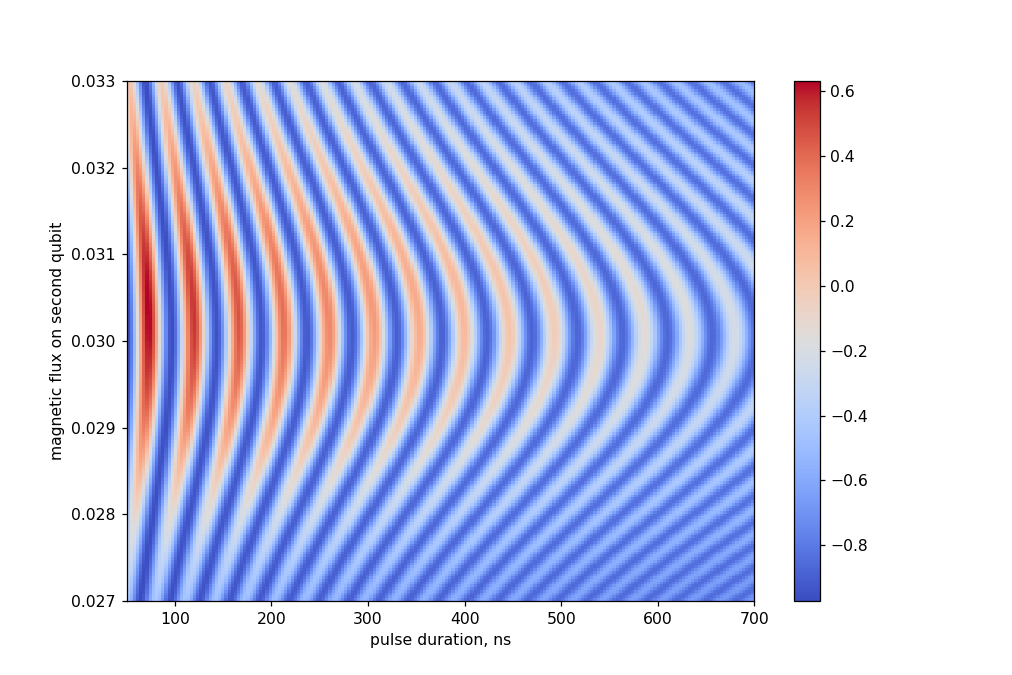

/tmp/ipykernel_2771395/2426902669.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  image = ax.pcolormesh(durations,phis,populations2, cmap = cm.coolwarm)


In [17]:
fig, ax = subplots(1,1,figsize=[9,6])
image = ax.pcolormesh(durations,phis,populations2, cmap = cm.coolwarm)
fig.colorbar(image, ax=ax)
ax.set_xlabel('pulse duration, ns')
ax.set_ylabel('magnetic flux on second qubit')
fig.savefig('04.02.2022_Vacuum_Rabi_big_decr.png')